# Project 4: Predicting West Nile Virus
## Team Purple Cobras - General Assembly Boston - DSI
## September 2018

# Model Building Notebook

Goal: Build a classification model to predict where and when West Nile Virus will be found in Chicago.

The purpose of this notebook is to build, run, and evaluate classification models.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix

%matplotlib inline

In [2]:
models = [] # Instantiate an empty list, which will hold dictionaries of model metrics

In [3]:
def plot_roc_auc(fpr, tpr, roc_auc):
    '''Plots the ROC-AUC for a given model and test data'''

    # Create a plot of the ROC-AUC Curve
    plt.figure(figsize = (10,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show()

In [4]:
def get_classification_results(model, model_name, X_train, X_test, y_train, y_test):
    '''For a classification model, predict y values and calculate Accuracy, return a confustion matrix,
    calculate TP, TN, FP, FN, and other metrics on both training and testing data'''
    
    # Training Scores
    y_predict_tr = model.predict(X_train)
    accuracy_train = model.score(X_train, y_train)
    
    # Testing Scores
    y_predict = model.predict(X_test)
    accuracy_test = model.score(X_test, y_test)
    precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_predict)
    
    # ROC-AUC
    probas = model.predict_proba(X_test)
    preds = probas[:,1]
    fpr, tpr, threshold = roc_curve(y_test, model.predict(X_test))
    roc_auc = auc(fpr, tpr)
    
    # Create dictionary to store model results
    model_dict = {
        'Model': model_name,
        'Train Accuracy': accuracy_train,
        'Test Accuracy': accuracy_test,
        'Precision': precision,
        'Recall': recall,
        'F_1 Score': fbeta_score,
        'Support': support,
        'ROC-AUC': roc_auc
    }
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_predict) 

    print(classification_report(y_test, y_predict), '\n')
    print('ROC-AUC: {}'.format(roc_auc))
    
    plot_roc_auc(fpr, tpr, roc_auc
                )
    return model_dict, cm

In [5]:
# Read in data
west_nile = pd.read_csv('../data/preprocessed_data')

# Set up X and y
features = ['pipiens', 'restuans', 'Latitude', 'Longitude', 'NumMosquitos', 'Tavg', 'PrecipTotal', 'StnPressure',
           'BR', 'HZ', 'RA', 'TSRA', 'VCTS', 'DZ', 'TS', 'FG']

X = west_nile[features]
y = west_nile['WnvPresent']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Note: 

Some debugging is needed to get the pipeline/gridsearch to work with the get_classification_results() function. For now, skip this cell and run a single model.

             precision    recall  f1-score   support

          0       0.95      0.98      0.97      2039
          1       0.27      0.12      0.17       114

avg / total       0.92      0.94      0.92      2153
 

ROC-AUC: 0.5523304337351471


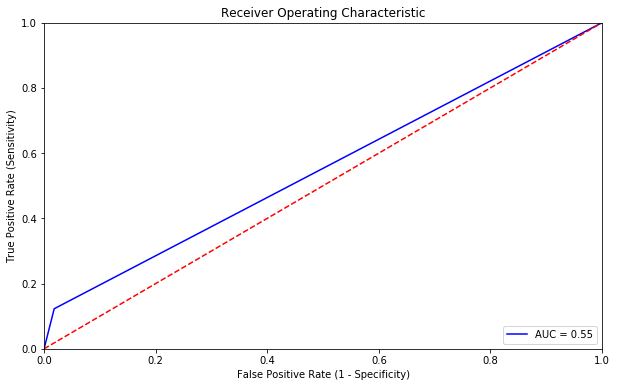

In [6]:
# Set up pipeline
steps = [
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
]

pipe = Pipeline(steps)

# Set up gridsearch
grid_params = {
    'poly__degree': [2],
    'poly__interaction_only': [True, False],
    'knn__n_neighbors': [3],
    'knn__p':[2]
}

gs = GridSearchCV(pipe, grid_params, scoring = 'roc_auc', n_jobs = -1)

# Fit model
model = gs.fit(X_train, y_train)

# Run and evaluate model
model_dict, cm = get_classification_results(gs, 'K-Nearest Neighbors',
                                            X_train, X_test,
                                            y_train, y_test)

             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2039
          1       0.37      0.06      0.11       114

avg / total       0.92      0.94      0.93      2153
 

ROC-AUC: 0.5277591354551164


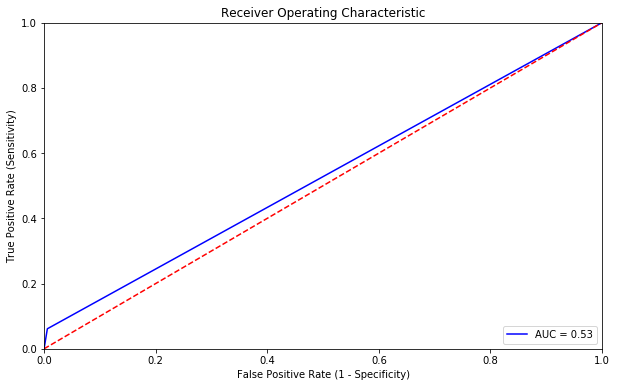

In [8]:
# Standard Scale data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

knn = KNeighborsClassifier() # Instantiate model
knn = knn.fit(X_train_scaled, y_train) # Fit model

# Run and evaluate model
model_dict, cm = get_classification_results(knn, 'K-Nearest Neighbors', 
                                            X_train_scaled, X_test_scaled, 
                                            y_train, y_test)